<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">


# DSI-13 Capstone Project: 
# Recommender Systems

_Authors: Davis Hong_

---

### Problem Statement:
A Recommender System refers to a system that is capable of predicting the future preference of a set of items for a user, and recommend somthing s/he likes (content based) or something preferred by other users with similar tastes (collaborative). In the past where brick and mortar is the norm, recommendations are usually made through word of mouth. However, with the internet, availability of large amount of data and fast computing power, recommendations not only can be done real-time but also fairly accurate. Recommendations are very common nowadays to the point, it has becoming 'in-your-face'. Businesses especially those relying heavily or solely on the internet for revenue, recommender systems will greatly boost the growth or even the very survival of the business.

There are many type of recommender systems but this project, we will focus on developing a recommender system to recommend movies to users based on a hybrid model;

<a id="two-classical-recommendation-methods"></a>
### Two classical recommendation methods

- **Collaborative Filtering**: _(similar people)_
    - If you like the same 5 movies as someone else, you'll likely enjoy other movies they like.
    - There are two main types: (a) Find users who are similar and recommend what they like (**user-based**), or (b) recommend items that are similar to already-liked items (**item-based**).
   

- **Content-Based Filtering** _(similar items)_
    - If you enjoy certain characteristics of movies (e.g. certain actors, genre, etc.), you'll enjoy other movies with those characteristics.
    - Note this can easily be done using machine learning methods! Each movie can be decomposed into features. Then, for each user we compute a model -- the target can be a binary classifier (e.g. "LIKE"/"DISLIKE") or regression (e.g. star rating).
<br>
The initial model is based on a simple non-machine learning model and the results will be compared with a machine learning based model. The machine learning model will be expected to produce better results.

Although there are many users and movie titles but in reality, not all users give their ratings which in a way is good. This means, we can recommend movies to users. Instead of storing all users and movies in matrix which can be very huge and take up a lot of memory, we can store the ratings in a sparse matrix which requires far less memory.
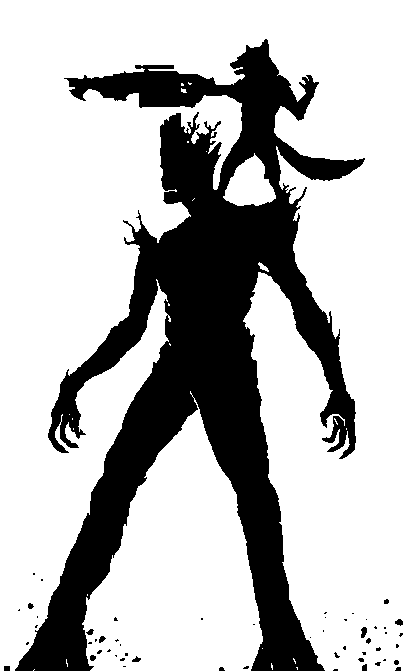

### Data Source:
Data source: The 1M Movie Lens datasets will be used for the project.

Datasets can be found at https://grouplens.org/datasets/movielens/1m/

Data dictionary: http://files.grouplens.org/datasets/movielens/ml-1m-README.txt


### Potential challenges and obstacles:
As there are no metrics to measure whether the recommender engine is good or not thus some form of human interpretation of the results will be required to gauge the performance of models.

### Measuring of results.
Whenever possible, baseline score will be set and metrics such as MSE, RSME, etc will be used to measure the effectiveness of the model.

Bearing any unforeseen circumstances for eg, interruptions cause by COVID19, this project should be achievable as data is available. Data cleaning is expected but minimal.

### Let's get started...

### Load required libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from scipy import sparse
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn import preprocessing
sns.set()
sns.set_style('darkgrid')
plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Load datasets
---

We'll be using the [MovieLens](https://grouplens.org/datasets/movielens/) dataset for building our recommendation engine. There are 3 datasets namely movies, ratings and users which will be used to build the recommender system. 

In [ ]:
# Load 1M datasets
warnings.filterwarnings('ignore')
movies = pd.read_csv('.\datasets\\movies.dat', sep="::", header=None)
ratings = pd.read_csv('.\datasets\\ratings.dat', sep="::", header=None)
users = pd.read_csv('.\datasets\\users.dat', sep="::", header=None)
movies.columns = ["movieid", "title", "genres"]
ratings.columns = ["userid", "movieid", "rating", "timestamp"]
users.columns = ["userid", "gender", "age", "occupation", "zipcode"]

In [ ]:
print(f'Shape of Movies dataframe: {movies.shape}\n')
print(f'Any null values in the dataframe:\n{movies.isnull().sum()}\n')
print(f'Data types:\n{movies.dtypes}')
movies.head()

In [ ]:
print(f'Shape of Ratings dataframe: {ratings.shape}\n')
print(f'Any null values in the dataframe:\n{ratings.isnull().sum()}\n')
print(f'Data types:\n{ratings.dtypes}')
ratings.head()

In [ ]:
print(f'Shape of Users dataframe: {users.shape}\n')
print(f'Any null values in the dataframe:\n{users.isnull().sum()}\n')
print(f'Data types:\n{users.dtypes}')
users.head()

In [ ]:
# Per data dictionary, there are additional information on the numeric codes 
# used in the users dataset. 

#Create dictionary for age group.
data = {'age': [1, 18, 25, 35, 45, 50, 56], 
        'agegrp': ['Under 18', '18-24', '25-34', '35-44', '45-49', '50-55', '56+']} 

# Create DataFrame for age group
age_grp = pd.DataFrame(data)

# Create dictionary for occupation
data = {'code': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 
        'occupation': ['other', 'academic/educator', 'artist', 'cleric/admin',
                       'college/grad student', 'customer service',
                       'doctor/health care', 'executive/managerial', 'farmer',
                       'homemaker', 'K-12 student', 'lawyer', 'programmer',
                      'retired', 'sales/marketing', 'scientist',
                      'self-employed', 'technician/engineer',
                      'tradesman/craftsman', 'unemployed', 'writer']} 

# Create DataFrame for age group
occupation = pd.DataFrame(data)

In [ ]:
age_grp

In [ ]:
occupation

## Drop unnecessary columns
---

We won't need the `timestamp` column from `ratings`, nor will we need the `genres` column from `movies`. Drop both columns in the cells below.

In [ ]:
movies.drop('genres', axis = 1, inplace = True)
ratings.drop('timestamp', inplace = True, axis = 1)

### Let's explore the movie dataset a bit more.

In [ ]:
# Extract movie titles excluding the year and concatenate the results into one long string
titles = movies['title'].str.extract('([a-zA-Z ]+)', expand=False).str.strip()
titles = ' '.join(titles)

In [ ]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(["groot", "guardians", "galaxy"])

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(titles)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Hum... say all you want, Man and Love still triumph! Somthing about time too - Day, Night and Time, that is.

In [ ]:
# Extract movie titles excluding the year and concatenate the results into one long string
genres = movies['genres'].str.extract('([a-zA-Z ]+)', expand=False).str.strip()
genres = ' '.join(genres)

In [ ]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(genres)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Interestingly, majority of the users like Drama and Comedy.

In [ ]:
x = []
y = []
rating = ratings['rating'].value_counts()
for i, v in rating.iteritems():
    x.append(i)
    y.append(v)

#tick_label does the some work as plt.xticks()
plt.bar(x, y,tick_label = x)
plt.xlabel('Rating')
plt.ylabel('Total Number of Users Ratings')
plt.title('Movielens Ratings')
plt.show()

### Generally and as expected, users are not ready to give a rating of 5 even when the movie is fantastic. A rating of 4 is consider very good and there are rooms for improvements.

## Merge `movies` and `ratings`
---

Use `pd.merge` to **inner join** `movies` with `ratings` on the `movieId` column.

In [ ]:
movie_ratings = pd.merge(ratings, movies, on = 'movieid')

In [ ]:
# Print first and last 5 rows of the merged dataframe
print(movie_ratings.head())
print(movie_ratings.tail())

## Create pivot table
---

Because we're creating an item-based collaborative recommender (where item in this case is our movies), we'll set up our pivot table as follows:
1. The `title` will be the index
2. The `userId` will be the column
3. The `rating` will be the value

**If we were building a user-based collaborative recommender, what would change about this pivot table?**

In [ ]:
pivot = pd.pivot_table(movie_ratings, index = 'title', columns='userid', values = 'rating')
pivot.head()

## Create sparse matrix
Calculate the cosine similarity for each movie using the `pairwise_distances` function. Before that, we need to create a sparse matrix (datatype) using `scipy`'s `sparse` module.

In [ ]:
sparse_pivot = sparse.csr_matrix(pivot.fillna(0))

In [ ]:
type(sparse_pivot)

## Calculate cosine similarity
Use `sklearn's` built-in `pairwise_distances` function for the recommender. It will return a square matrix, comparing every movie with every other movie in the dataset.

In [ ]:
# Create a distance metrics similar to    
recommender = pairwise_distances(sparse_pivot, metric = 'cosine')

In [ ]:
recommender_df = pd.DataFrame(recommender, columns = pivot.index, index = pivot.index)

In [ ]:
recommender_df.head()

## Create distances DataFrame
---

At this point, we essentially have a recommender. We'll load it into a `pandas` DataFrame for readability. 

You'll notice that each movie has a "distance" of 0 with itself (along the diagonal).

## Evaluate recommender performance
---

Now comes the fun part! Let's check out a few movies to see if the recommender aligns with our intuition. In the cell below we'll do the following:
1. Create a search term
2. Use that to find all titles matching the search query
3. For each title, we'll list off the following:
  1. The average rating
  2. The number of ratings
  3. The ten most similar movies

In [ ]:
# Camel case the search string with .title() as movie titles are camel cased
search = input("What is your favorite movie: ").title()

In [ ]:
for title in movies.loc[movies['title'].str.contains(search), 'title']:
    print(title)
    print(f'Average rating: {round(pivot.loc[title, :].mean(),1)}') # Average ratings from users
    print(f'Number of rating: {pivot.loc[title, :].count()}')
    print('')

In [ ]:
for title in movies.loc[movies['title'].str.contains(search), 'title']:
    print(title)
    print(f'Average rating: {round(pivot.loc[title, :].mean(),1)}') # Average ratings from users
    print(f'Number of rating: {pivot.loc[title, :].count()}')
    print('')
    print('Here are some movies you may like:')
    print('')
    print(recommender_df[title].sort_values()[1:6])
    l = 
    print('')
    print('*' * 70)
    

In [ ]:
l = [i for i in recommender_df[title]]
l[0]